## CAMERA CALIBRATION
It's neccessary to calibrate the camera if we want to correctly determine the location of an object in the picture. Calibration consists of 3 steps
1. Find chessboard-corners in a dataset of images containing a chessboard.
2. Use the corner points to compute a camera matrix.
3. Use the camera matrix to undistort images.

In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob


# Variables that describe size of the checkerboard pattern
nb_horizontal = 6
nb_vertical = 6

# Create a 2D matrix where each element contains 3 zeros -> [[0,0,0], [0,0,0], ...] Why 3? Because those are X Y Z coordinates.
objpoints = np.zeros((nb_horizontal*nb_vertical,3), np.float32)

# Assigns 2D grid of coordinates for the checkerboard pattern 
# Example: np.mgrid[0:3, 0:2] does this array([[[0, 1], [0, 1], [0, 1]],          [[0, 0], [1, 1], [2, 2]]])
# Then the matrix is transposed and reshaped so it looks like this -> [[[0, 0], [1, 0], [2, 0],.....]
objpoints[:, :2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objectpoints = [] # 3d point in real world space
imagepoints = [] # 2d points in image plane.

images = glob.glob('calib/*.png')


for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    ret, corners = cv.findChessboardCorners(gray, (nb_horizontal, nb_vertical), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objectpoints.append(objpoints)

        imagepoints.append(corners)

        # Draw and display the corners
        img = cv.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        cv.imshow('img',img)
        cv.waitKey(500)
    else:
        print(f"Chessboard corners not detected in {fname}")

cv.destroyAllWindows()

Chessboard corners not detected in calib\1403709004387836928.png
Chessboard corners not detected in calib\1403709009887836928.png
Chessboard corners not detected in calib\1403709012837837056.png
Chessboard corners not detected in calib\1403709015687836928.png
Chessboard corners not detected in calib\1403709022687836928.png
Chessboard corners not detected in calib\1403709029037837056.png
Chessboard corners not detected in calib\1403709030837837056.png
Chessboard corners not detected in calib\1403709032537837056.png
Chessboard corners not detected in calib\1403709036087836928.png
Chessboard corners not detected in calib\1403709042537837056.png
Chessboard corners not detected in calib\1403709047537837056.png
Chessboard corners not detected in calib\1403709060287836928.png
Chessboard corners not detected in calib\1403709067387836928.png
Chessboard corners not detected in calib\1403709074487836928.png
Chessboard corners not detected in calib\1403709077737837056.png
Chessboard corners not de

## CAMERA INTRINSIC PARAMETERS
Now that we have the checkerboard corners we can perform camera calibration.
- mtx -> camera matrix [fx,  0, cx], [ 0, fy, cy], [ 0,  0,  1] (fx and fy are focal lengths, cx and cy are the optical center)
- dist -> distortion coefficients - they describe the lens distortions that are warping the straight lines
- rvecs -> rotational vectors - they describe the orientation of the camera in the world
- tvecs -> translation vectors - they represent the position of the camera in the world

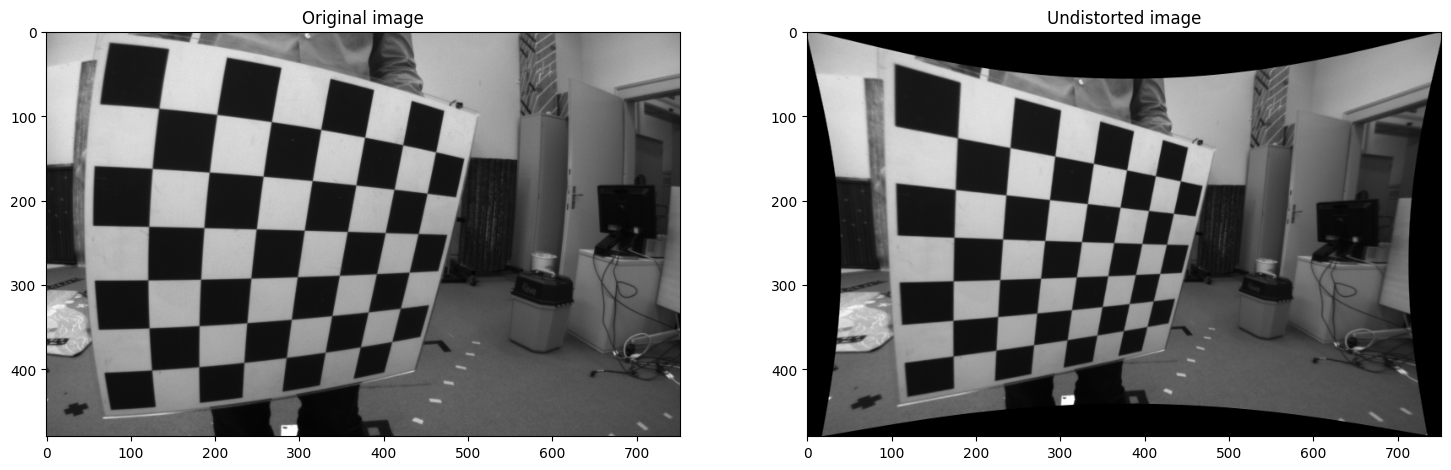

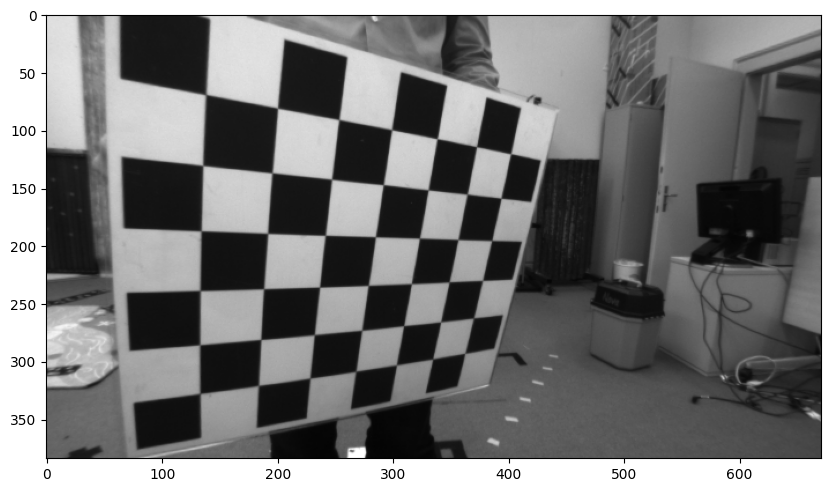

In [16]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objectpoints, imagepoints, gray.shape[::-1], None, None)


# Taking one picture from the calibration images
img = cv.imread('calib/1403709080387836928.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

dst = cv.undistort(img, mtx, dist, None, newcameramtx)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img[...,[2,1,0]])
ax[0].set_title('Original image')
ax[1].imshow(dst[...,[2,1,0]])
ax[1].set_title('Undistorted image')

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(dst[...,[2,1,0]])


# Epipolar geometry
Describes the geometric relationship between to views of a 3D scene. Used tofind corresponding points between two images.
The first thing that's usually done is detecting keypoints in both images with a feature detector such as SIFT
SIFT - Scale-Invariant Feature Transform - is a feature detection and description algorithm in computer vision. It is widely used for object recognition, image stitching, and feature matching.
How to use it?
1. Initialize SIFT -> sift = cv.SIFT_create()
2. keypoints, descriptors = sift.detectAndCompute(img, None)

- Keypoints - location, size and angle of the features detected
- Descriptors - Each descriptor is a 128-dimensional vector that describes the local neighborhood of a keypoint. It is used to match features between images.

Text(0.5, 1.0, 'Features')

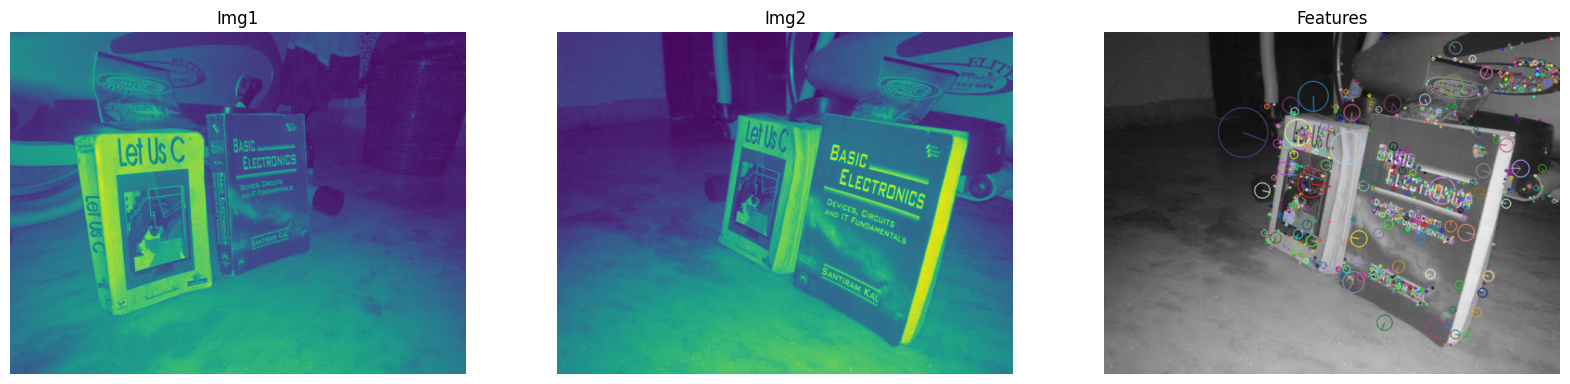

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Flag = 0 so the image is read in grayscale
img1 = cv.imread("pics/img_left.jpg", 0) 
img2 = cv.imread("pics/img_right.jpg", 0)

sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp_img = cv.drawKeypoints(img2, kp2, img2, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


fig, axes = plt.subplots(1, 3, figsize=(20, 20)) 

axes[0].imshow(img1)
axes[0].axis('off')
axes[0].set_title('Img1')

axes[1].imshow(img2)
axes[1].axis('off')
axes[1].set_title('Img2')

axes[2].imshow(kp_img)
axes[2].axis('off')
axes[2].set_title('Features')



## FUNDAMENTAL MATRIX
It relates corresponding points in two images. The fundamental matrix describes the epipolar geometry between two views.
This matrix allows you to calculate epipolar lines: lines in one image that correspond to the potential locations of points in the other image.

RANSAC - RAndom SAmple Consensus
- This algorithm chooses n random samples and fits model with them. After that it counts the number of data points that fits the model and repeats the whole process a couple of times. At the end the model with the most samples that fit is choosen.

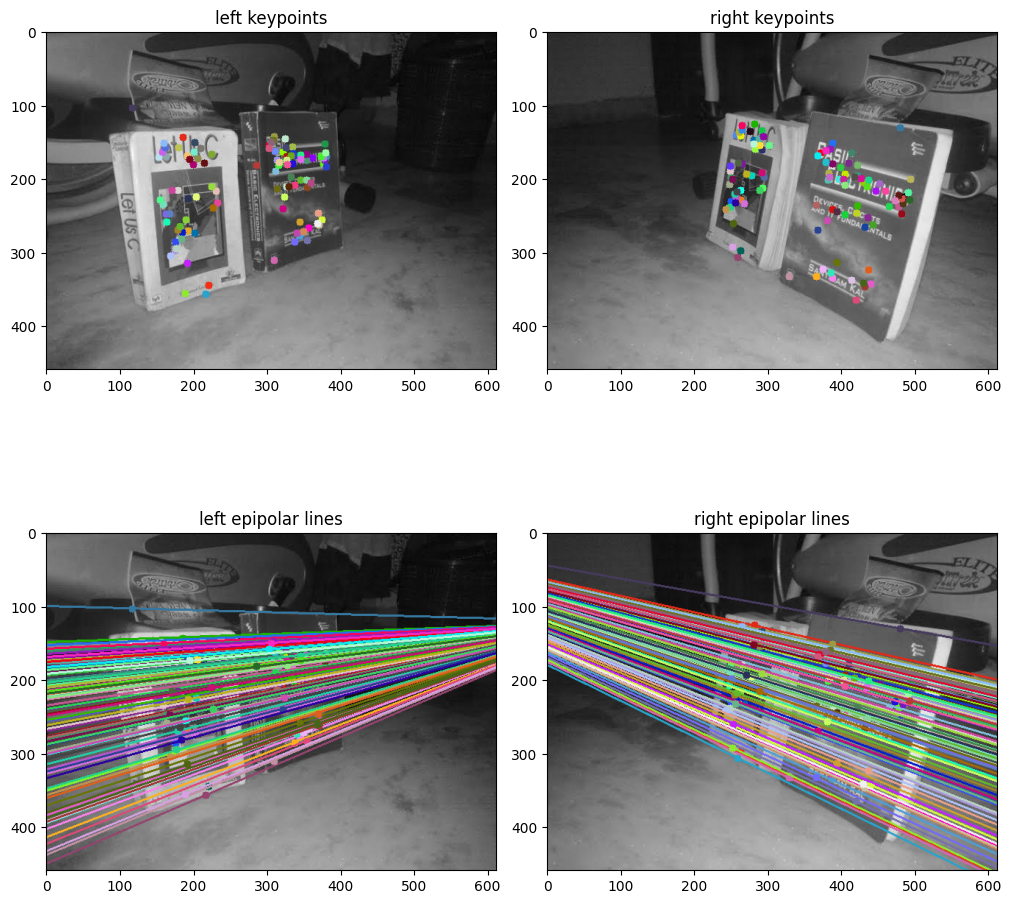

In [ ]:
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

# Sort the matches, compares the distances between the matches on first and second picture and sorts them according to their values, because typically the matches with lowest distances are the best
matches = sorted(matches, key = lambda x:x.distance)

nb_matches = 200

good = [] # For storing good matches
pts1 = [] # To store the corresponding points from image 1
pts2 = [] # To store the corresponding points from image 2

# Select the top 200 matches or whatever the value of nb_matches is
for m in matches[:nb_matches]:
    good.append(m)
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Finding fundamental matrix with a specific algorithm, here RANSAC
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)


# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]


def drawlines(img1,img2,lines,pts1,pts2):
    # img1 - image on which we draw the epilines for the points in img2 lines - corresponding epilines
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
axs[0, 0].imshow(img4)
axs[0, 0].set_title('left keypoints')
axs[0, 1].imshow(img6)
axs[0, 1].set_title('right keypoints')
axs[1, 0].imshow(img5)
axs[1, 0].set_title('left epipolar lines')
axs[1, 1].imshow(img3)
axs[1, 1].set_title('right epipolar lines')
plt.show()